In [1]:
import matplotlib.pyplot as plt
from glob import glob
from os import path
import torch
from torchvision.utils import save_image
import torch.nn as nn
from torch.nn import init
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
import numpy as np
import torch.nn.functional as F
import cv2
import PIL
from IPython.display import clear_output
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [2]:
def train_valid_split(data, target, rate):
    assert len(data) == len(target)
    
    total_num = len(data)
    valid_num = int(total_num*rate)
    train_num = total_num - valid_num
    
    train_ind = np.arange(total_num)
    valid_ind = np.random.randint(0, total_num, size=valid_num)
    train_ind = np.setdiff1d(train_ind, valid_ind)
    train_data = []
    train_target = []
    valid_data = []
    valid_target = []
    
    for i in train_ind:
        train_data.append(data[i])
    for i in train_ind:
        train_target.append(target[i])
    for i in valid_ind:
        valid_data.append(data[i])
    for i in valid_ind:
        valid_target.append(target[i])

    
    return train_data, train_target, valid_data, valid_target

In [3]:
class Classification_Dataset(Dataset):
    def __init__(self, imgList, targetList):
        self.imgList = imgList
        self.targetList = targetList

    def __len__(self):
        assert len(self.imgList) == len(self.targetList)
        
        return len(self.imgList)


    def __getitem__(self, index):   
        image = Image.open('./image/{}.png'.format(self.imgList[index])).convert('L')
        target = Image.open('./target/{}.png'.format(self.targetList[index])).convert('L')
        target = target.transpose(PIL.Image.TRANSPOSE)
        trans = transforms.Compose([transforms.ToTensor()])
        image = trans(image)
        target = trans(target)
            
        return image, target

In [4]:
import os

DIR_IN = "./image/"
DIR_IN = "./target/"

file_list = os.listdir(DIR_IN)
image = sorted([int(file[:-4]) for file in file_list if file.endswith(".png")])
target = sorted([int(file[:-4]) for file in file_list if file.endswith(".png")])

In [5]:
train_image, train_target, valid_image, valid_target = train_valid_split(image, target, rate=0.4)

In [6]:
dataset = Classification_Dataset(image, target)
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=240, shuffle=False)

In [7]:
image_size = 512
train_dataset = Classification_Dataset(train_image, train_target)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True)

In [8]:
valid_dataset = Classification_Dataset(valid_image, valid_target)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=9, shuffle=True)

In [27]:
test = next(iter(dataset_loader))

In [10]:
test[0].shape

torch.Size([240, 1, 512, 512])

In [11]:
test[1].shape

torch.Size([240, 1, 512, 512])

## video

<video controls src="./masking.mp4" width=400 height=400 />

In [29]:
# def imshow1(img):
#     plt.imshow(img, cmap='gray',  interpolation='none')
# def imshow2(mask):
#     plt.imshow(mask, cmap=map_object, alpha=0.7,  interpolation='none')
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import LinearSegmentedColormap

# # get colormap
# ncolors = 256
# color_array = plt.get_cmap('gist_rainbow')(range(ncolors))

# # change alpha values
# color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

# # create a colormap object
# map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)


# for pic, tar in zip(test[0], test[1]):
#     plt.figure(figsize=(12,12))

#     plt.subplot(2,2,1)
#     imshow1(torch.squeeze(pic).numpy())
#     imshow2(torch.squeeze(tar).numpy())
#     plt.subplot(2,2,2)
#     plt.imshow(torch.squeeze(pic).numpy(), cmap='gray')
#     plt.show()
#     clear_output(wait=True)

## Architecture

![alt text](https://miro.medium.com/max/780/1*PdYEf-OuUWkRsm2Lfrmy6A.png)


## Model

In [13]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        # number of input channels is a number of filters in the previous layer
        # number of output channels is a number of filters in the current layer
        # "same" convolutions
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out


class AttentionUNet(nn.Module):

    def __init__(self, img_ch=3, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """
        e : encoder layers
        d : decoder layers
        s : skip-connections from encoder layers to decoder layers
        """
        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

        e5 = self.MaxPool(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        s4 = self.Att5(gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1) # concatenate attention-weighted skip connection with previous layer output
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)

        return out


In [14]:
def dice_coeff(prediction, target):

    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1

    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)
    epsilon = 1e-6
    result = np.mean(2 * inter / (union + epsilon))
    return result


class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        
        # inputs and targets are assumed to be BatchxClasses
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)
           
        # compute the negative likelyhood
        logpt = - F.binary_cross_entropy_with_logits(input, target)
        pt = torch.exp(logpt)

        # compute the loss
        focal_loss = -( (1-pt)**self.gamma ) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss


In [ ]:
model = AttentionUNet(1, 1)
num_epoch = 30
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = FocalLoss(gamma=2)

NameError: name 'AttentionUNet' is not defined

In [21]:

def Bimshow(img):
    plt.imshow(np.transpose(img), cmap='gray')  
    
model = model.to(device)
train_loss_list = []
valid_loss_list = []
for i in tqdm(range(num_epoch)):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    
    for image,label in tqdm(train_loader):
      
        optimizer.zero_grad()
        image = image.to(device)
        label = label.to(device)
        output = model(image)
        
        loss = loss_func(output, label)
        loss.backward()
        optimizer.step()
        print(loss.item(),loss.item()*image.size(0),image.size(0))
        train_loss += loss.item()*image.size(0)
        
    model.eval()
    
    for image, label in tqdm(valid_loader):
      
        image = image.to(device)
        label = label.to(device)
        
        output = model(image)
        
        loss = loss_func(output, label)
        
        valid_loss += loss.item()*image.size(0)
    # else:    
    #     for i in range(image.shape[0]):
    #         if i == 3:
    #             break
    #         plt.figure(figsize=(25, 25))
    #         plt.subplot(1,2,1)
    #         Bimshow(torch.squeeze(output[i]).detach().cpu().numpy())
    #         plt.subplot(1,2,2)
    #         Bimshow(torch.squeeze(label[i]).detach().cpu().numpy())
    #         plt.show()
    
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    
    
    print('train_loss : {}, valid_loss : {}'.format(train_loss, valid_loss))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    # dice_loss_list.append(dice_loss)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/2538 [00:00<?, ?it/s]

0.016036471351981163 0.08018235675990582 5
0.014639935456216335 0.07319967728108168 5


KeyboardInterrupt: 

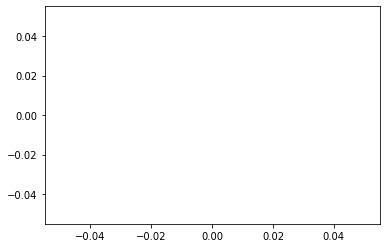

In [21]:
plt.plot(train_loss_list)
plt.plot(valid_loss_list)


In [22]:
# torch.save(model.state_dict(), "30_epoch.pt")

In [30]:
model.load_state_dict(torch.load("30_epoch.pt"))

<All keys matched successfully>

In [31]:
model = model.to(device)
test_image, test_target = next(iter(valid_loader))
test_image = test_image.to(device)
test_target = test_target.to(device)

In [32]:
test_image.shape

torch.Size([9, 1, 512, 512])

In [33]:
out = model(test_image)
# out[out < 0] = 0
# out[out > 0] = 1

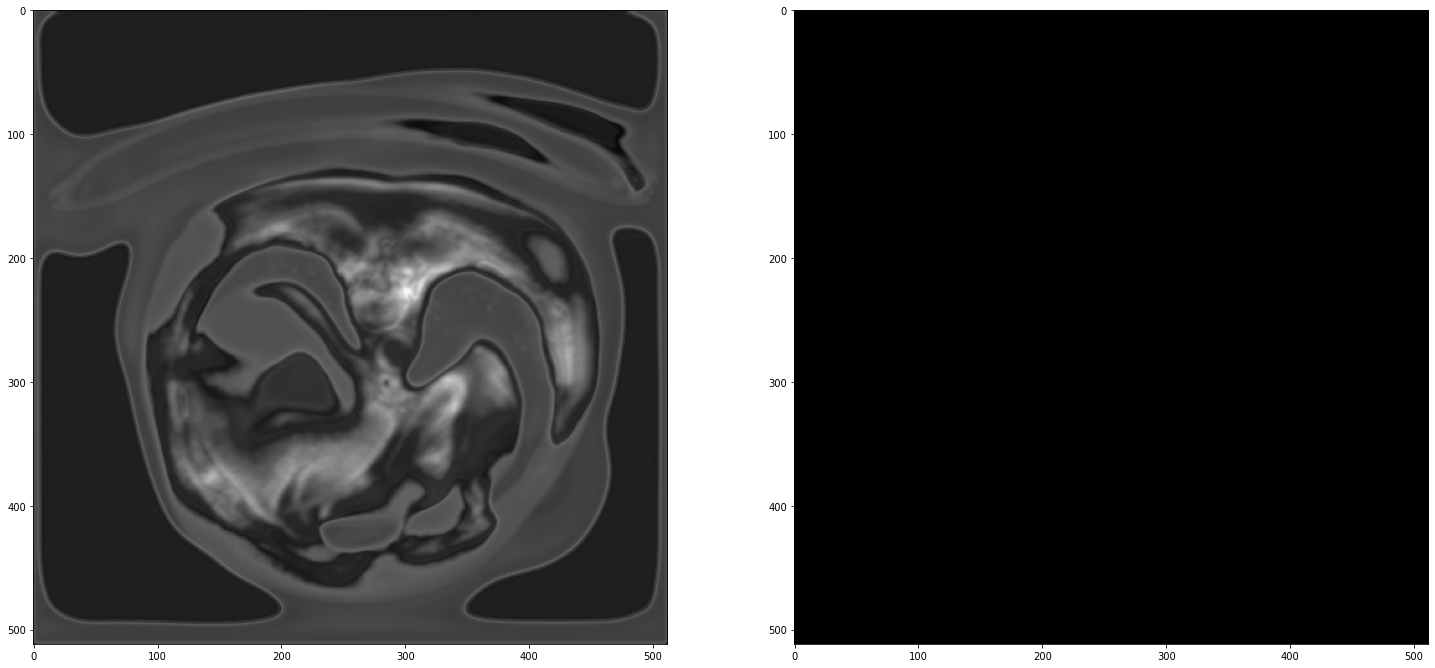

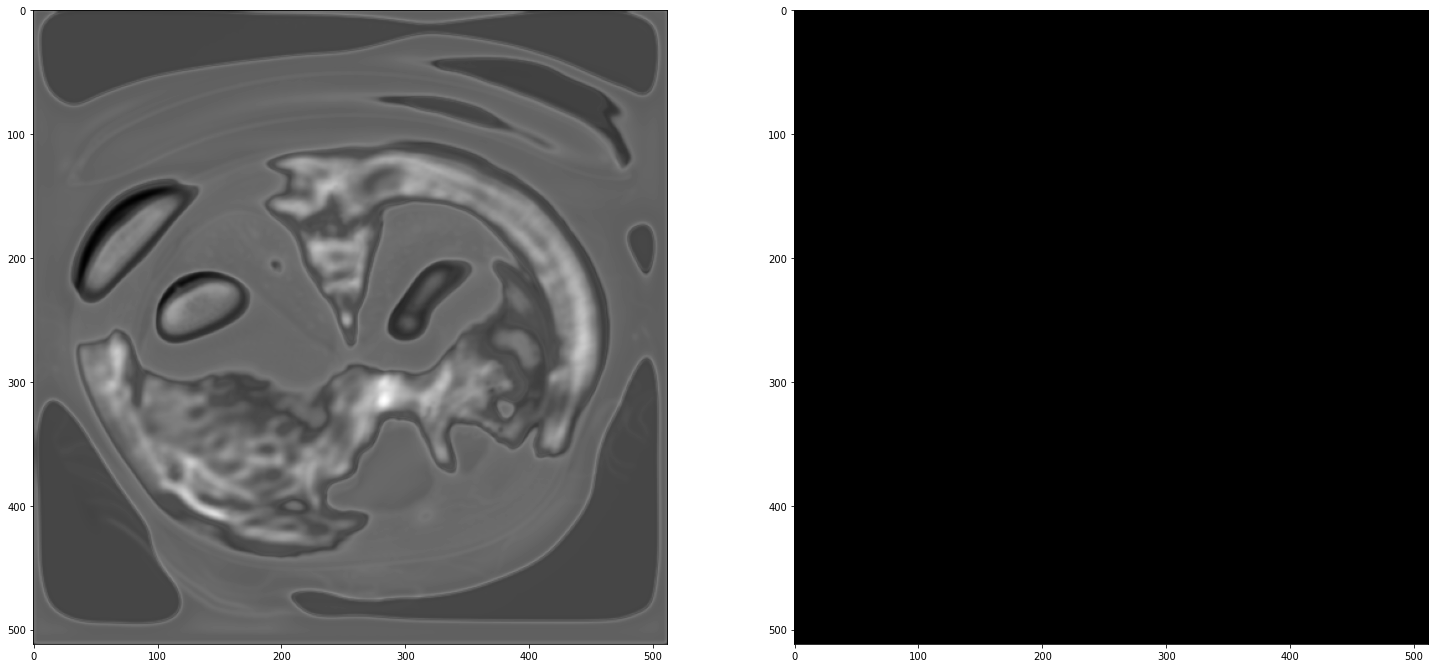

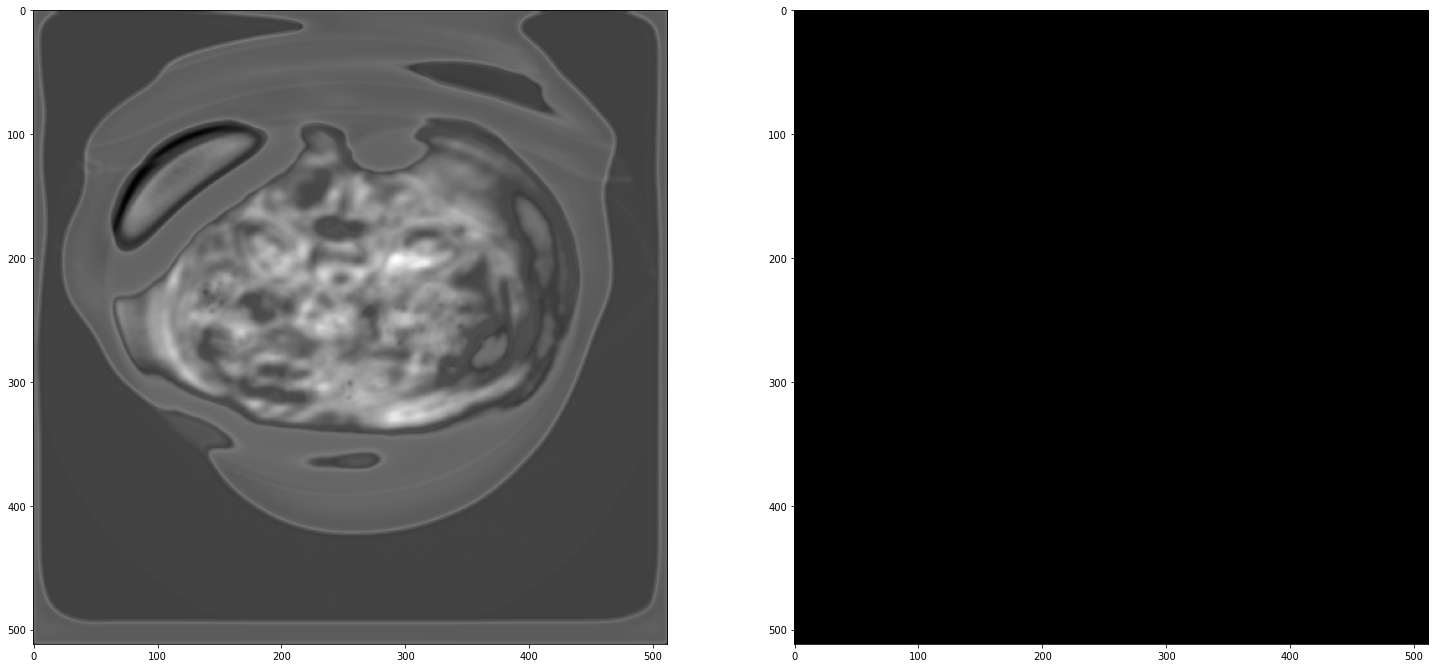

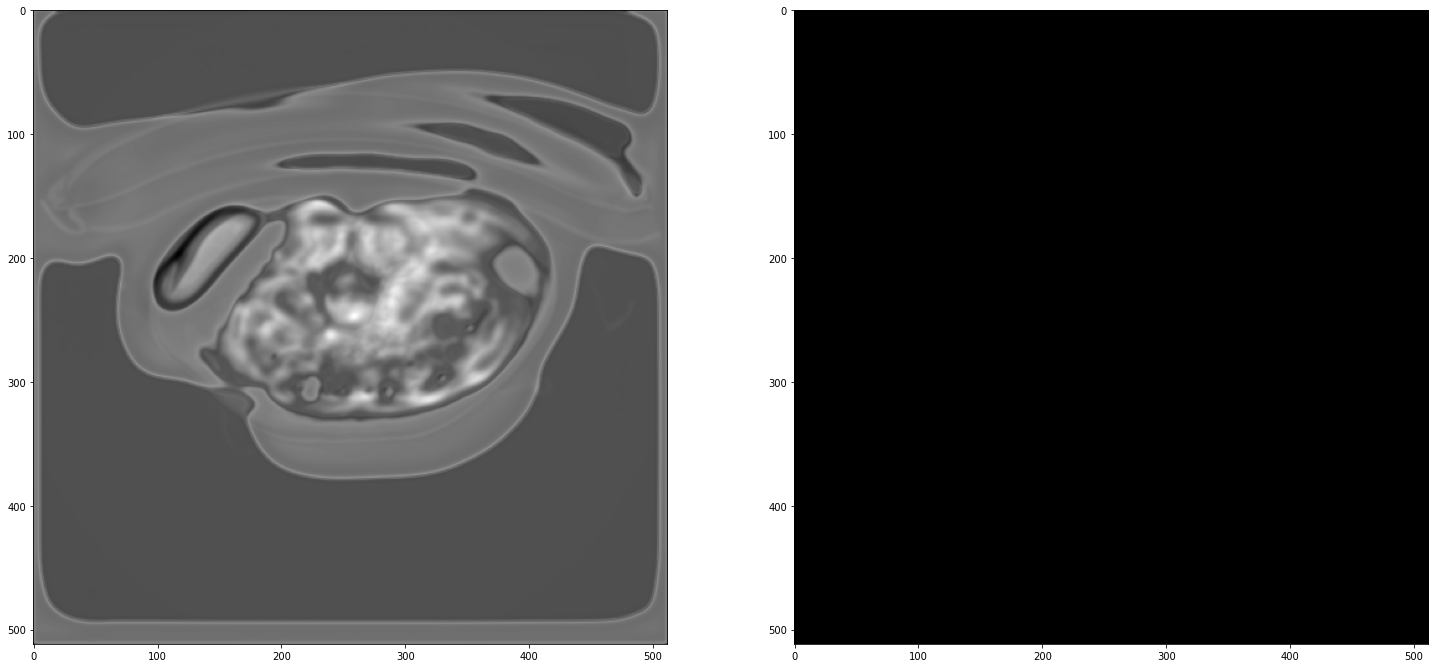

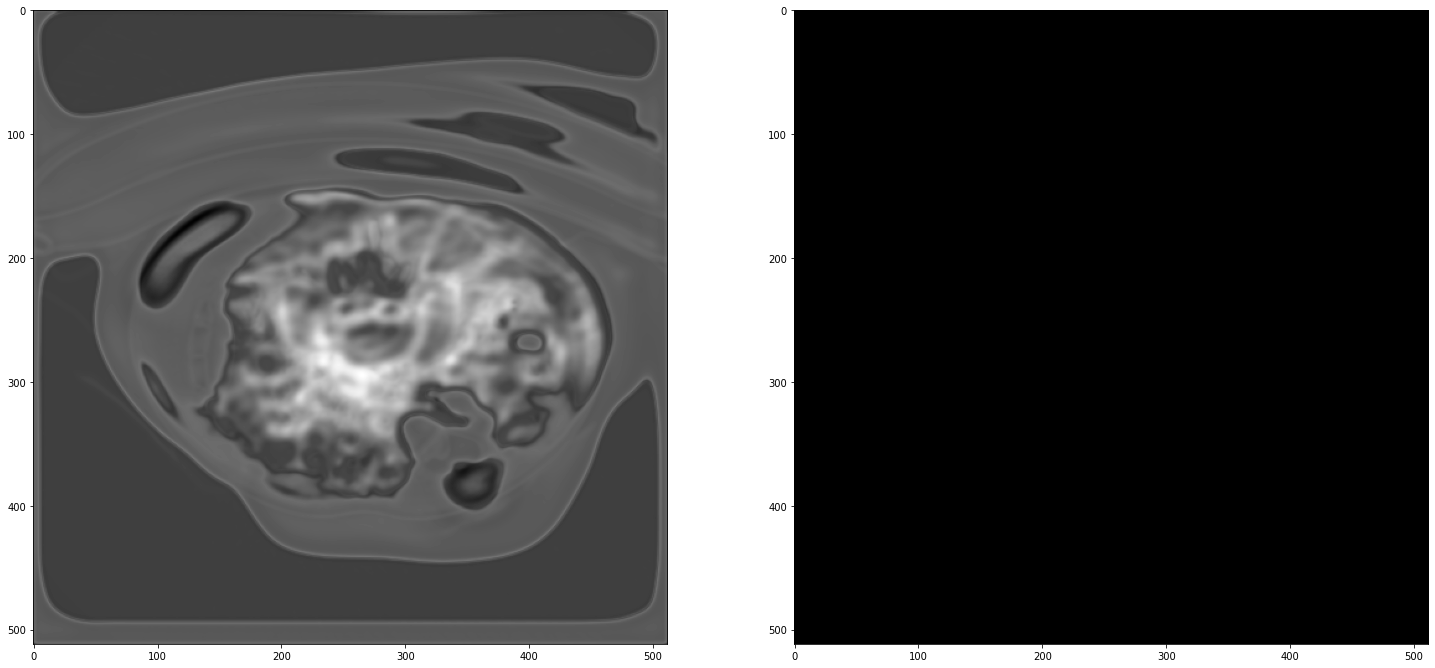

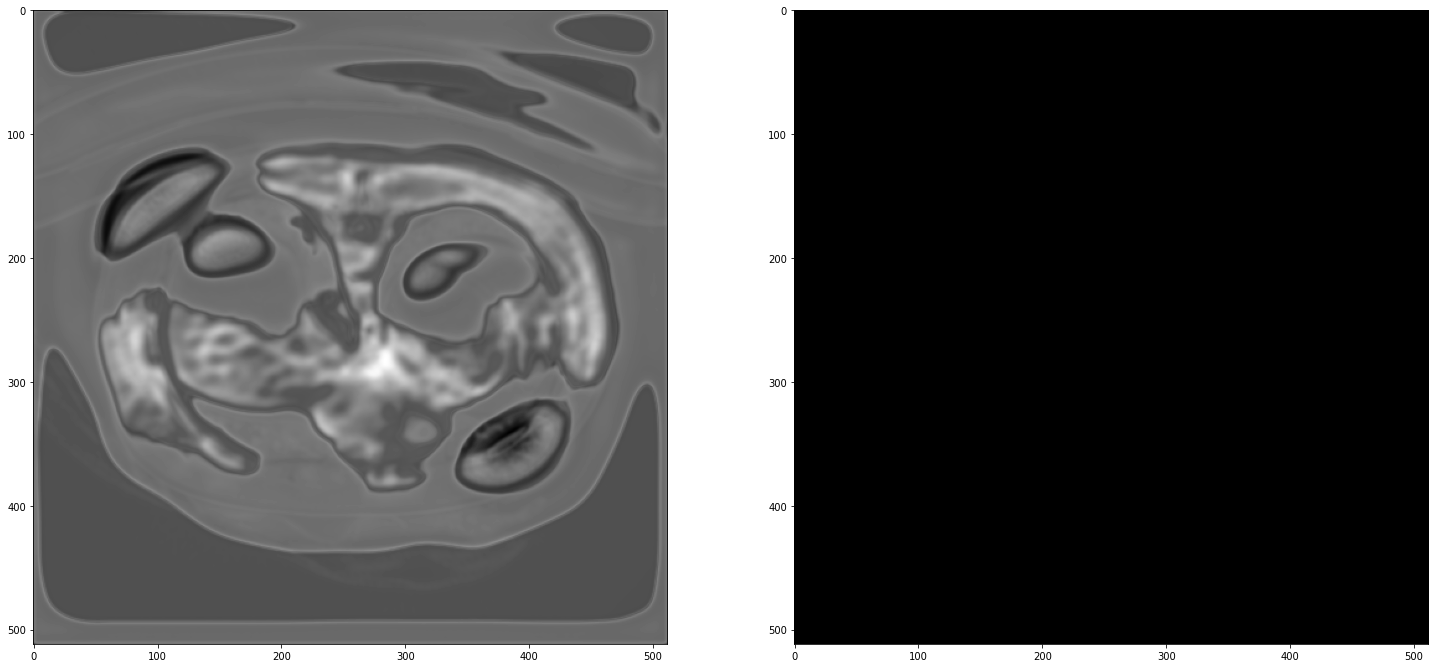

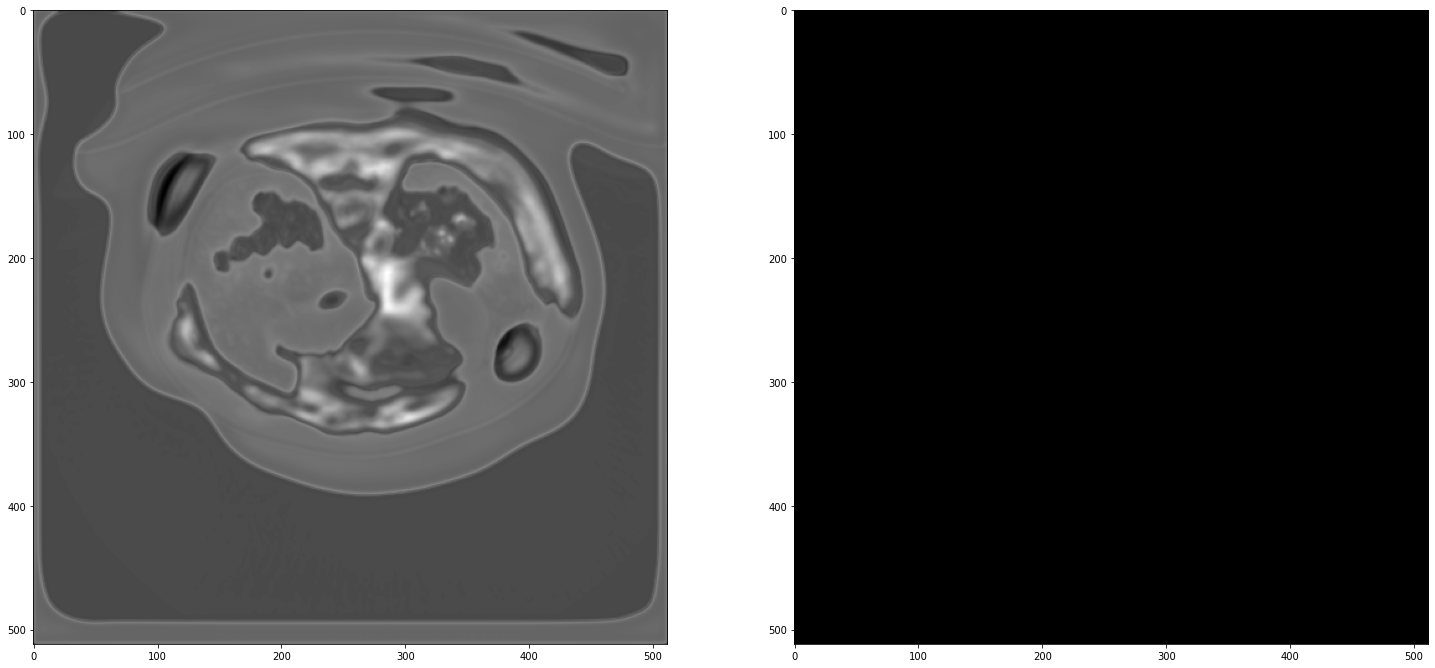

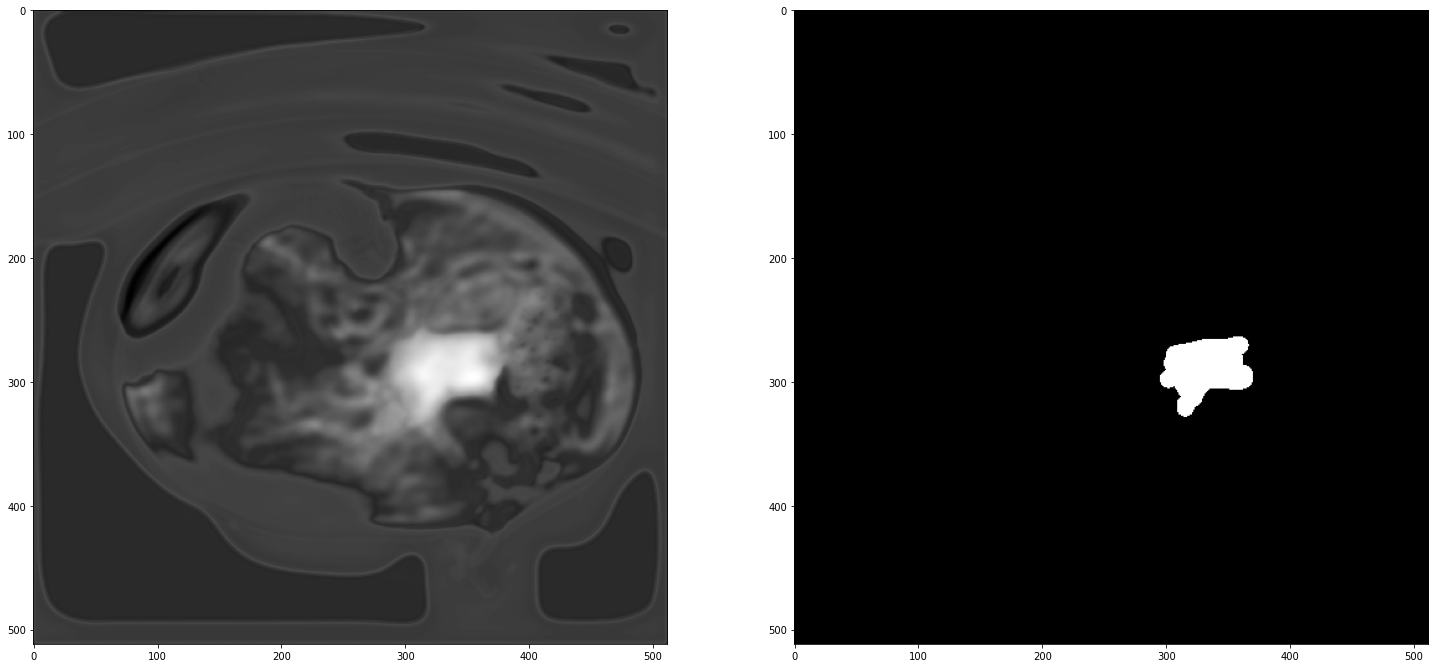

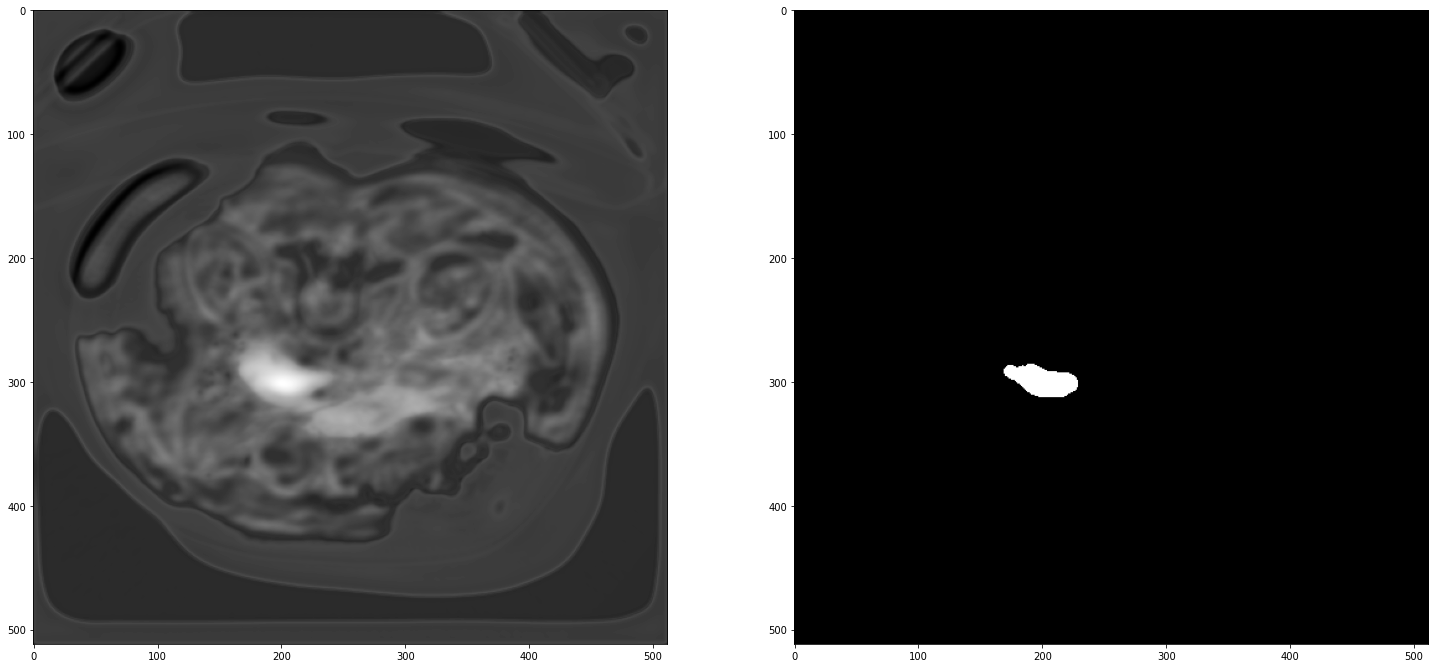

In [20]:
def Bimshow(img):
    plt.imshow(img, cmap='gray') 
for i, t in zip(out, test_target):
    plt.figure(figsize=(25, 25))
    plt.subplot(1,2,1)
    Bimshow(torch.squeeze(i).detach().cpu().numpy())
    plt.subplot(1,2,2)
    Bimshow(torch.squeeze(t).detach().cpu().numpy())
    plt.show()

In [18]:
out = model(test_image)
out[out < 0] = 0
out[out > 0] = 1

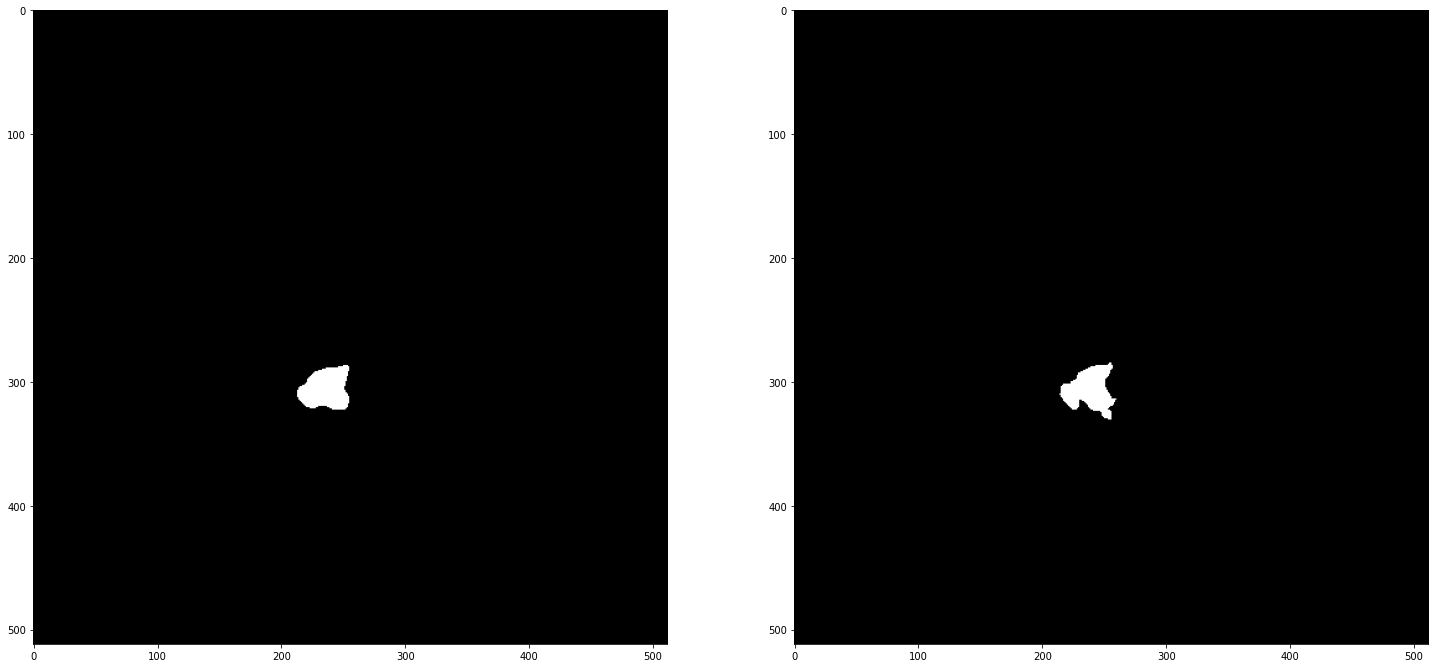

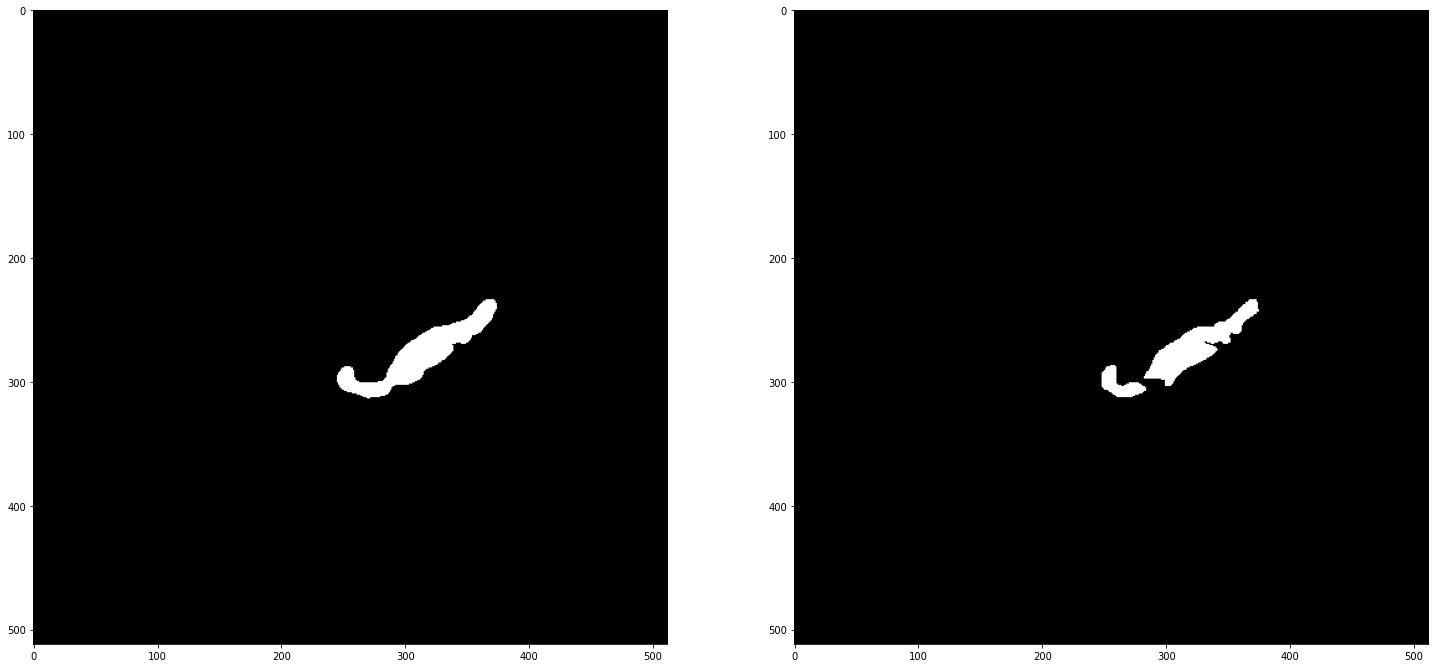

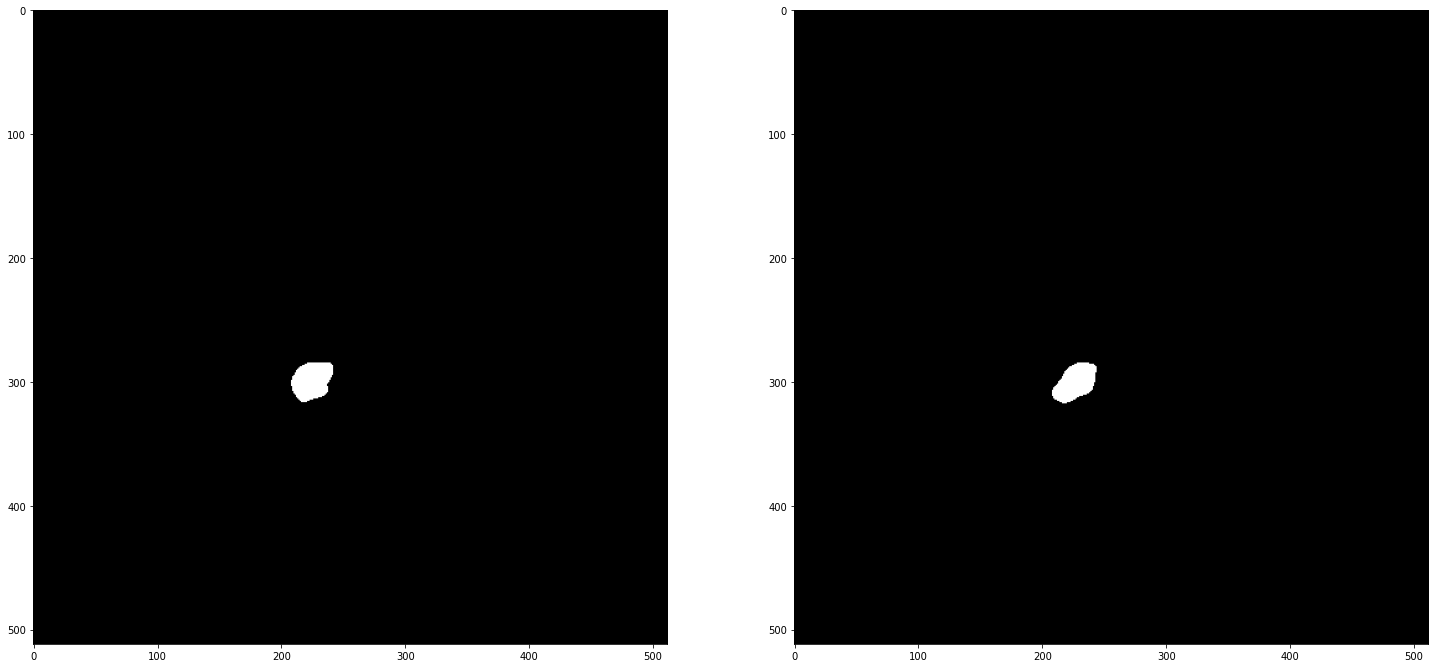

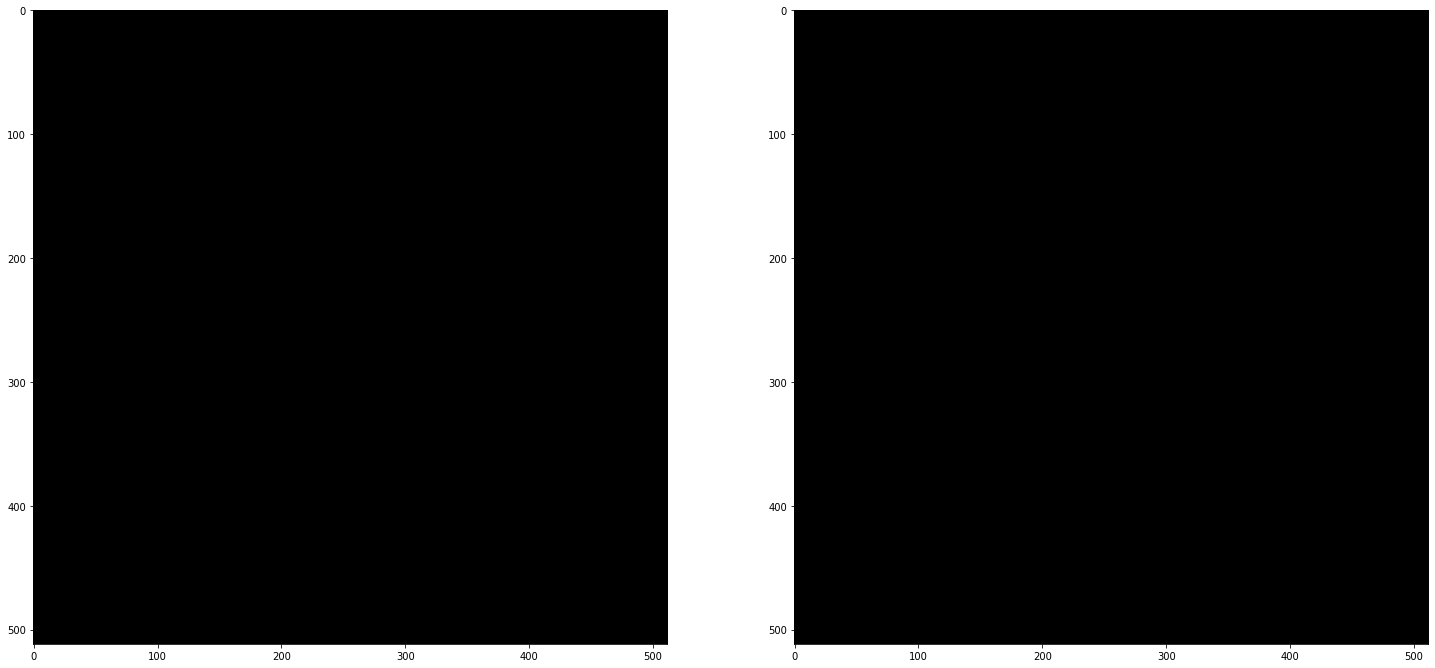

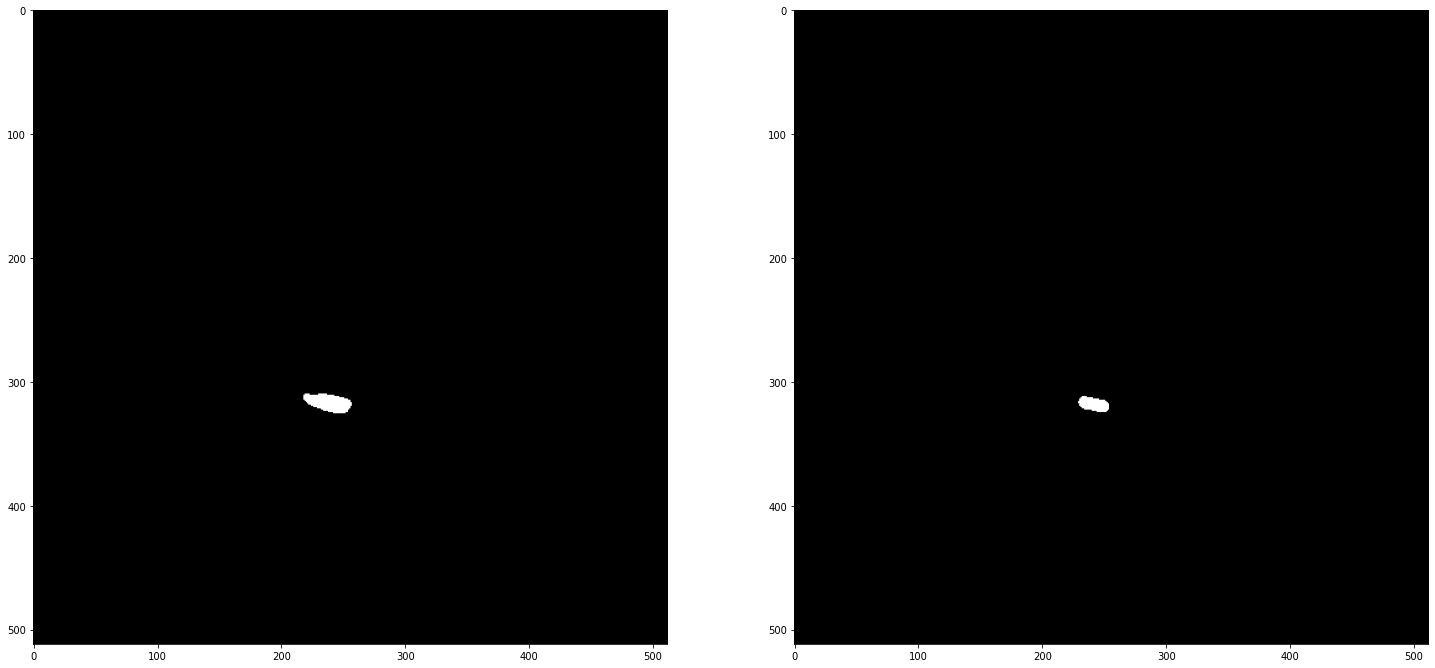

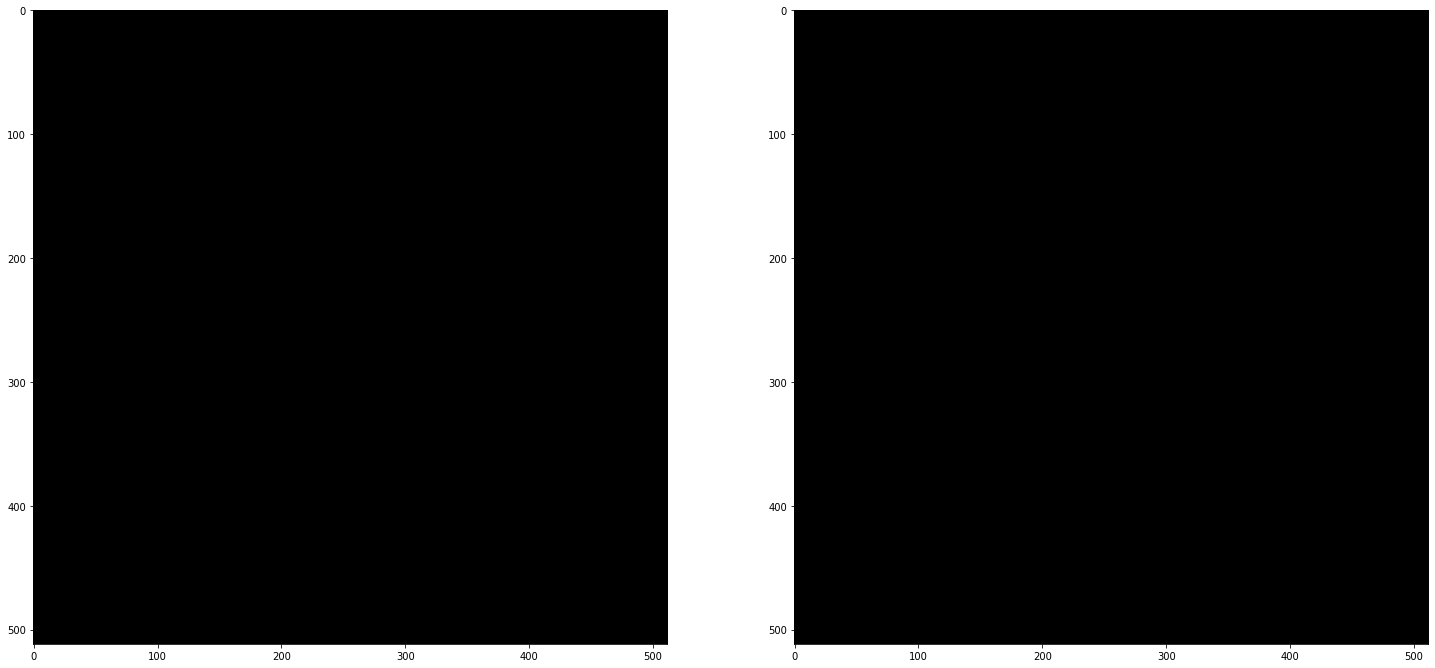

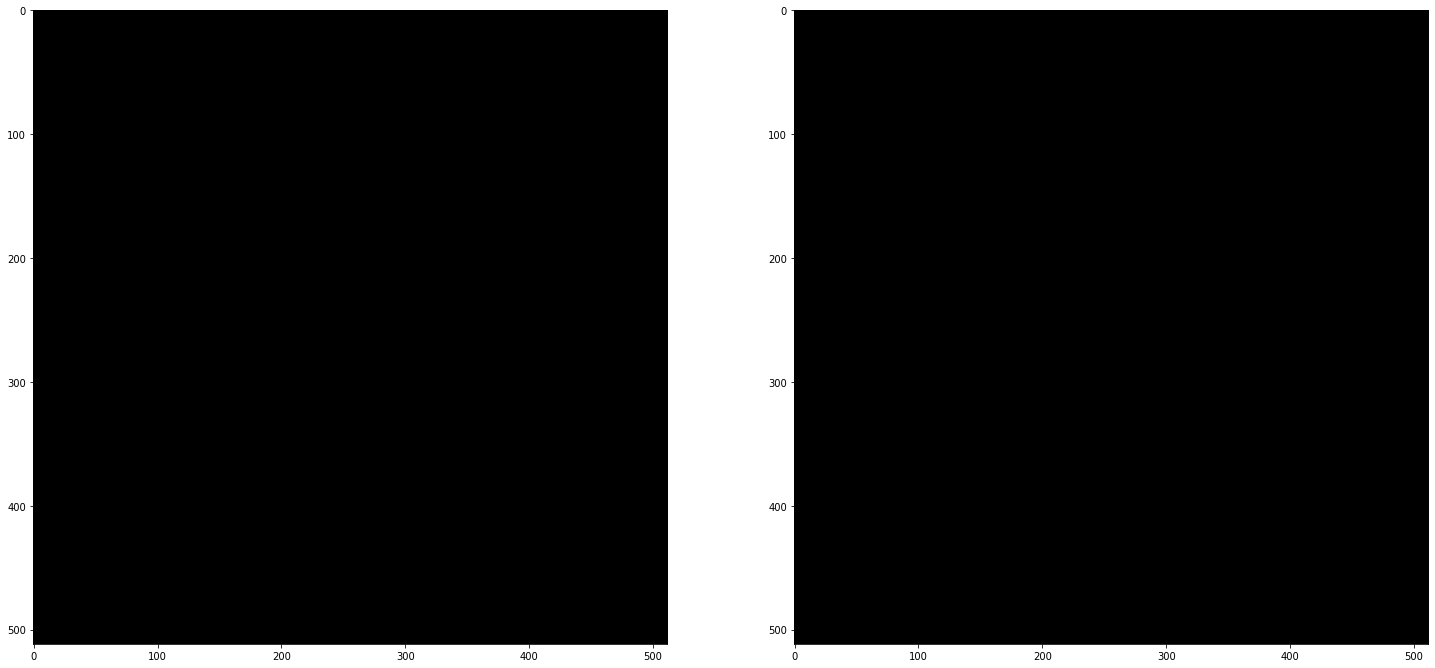

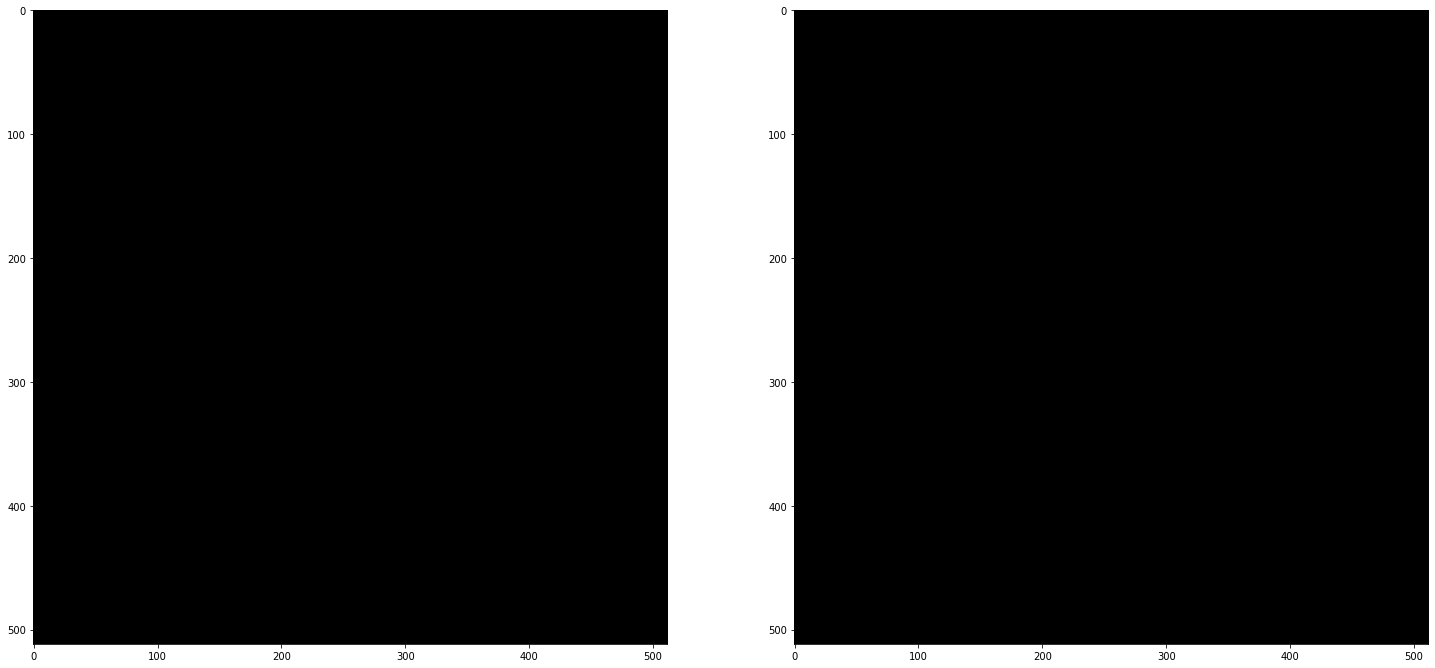

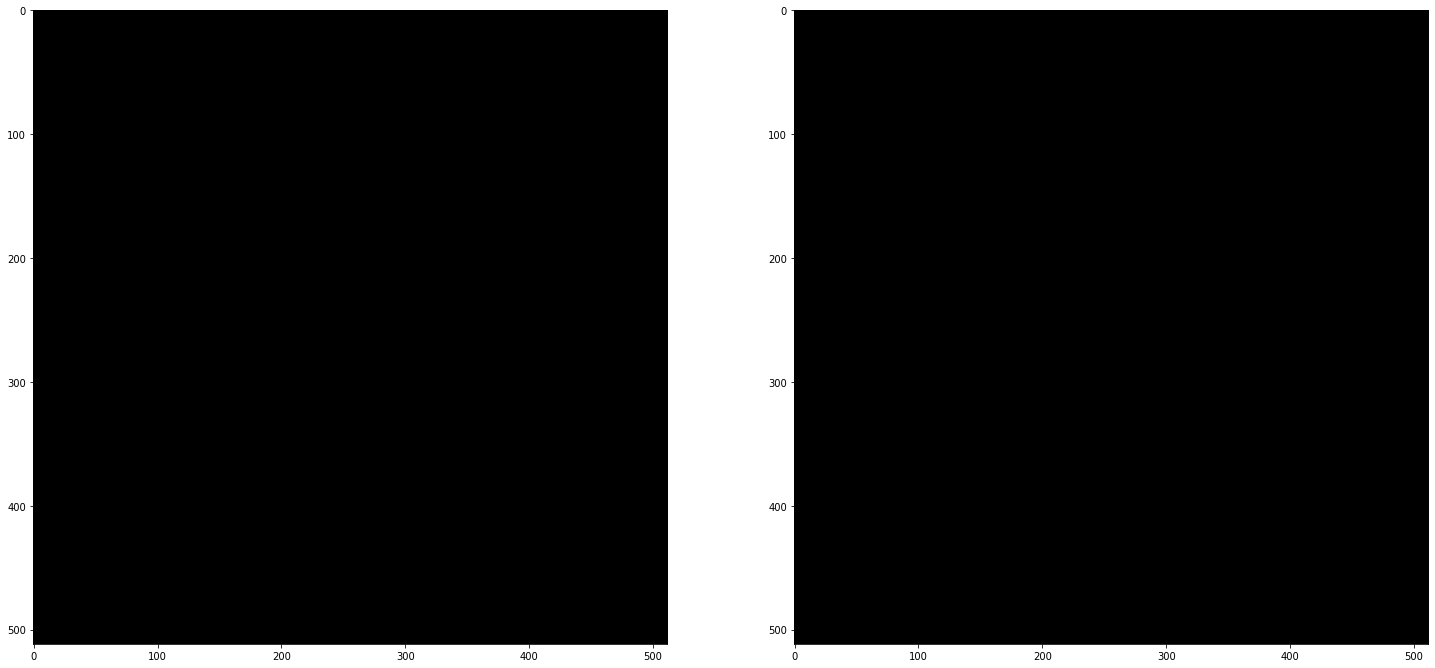

In [19]:
def Bimshow(img):
    plt.imshow(img, cmap='gray') 
for i, t in zip(out, test_target):
    plt.figure(figsize=(25, 25))
    plt.subplot(1,2,1)
    Bimshow(torch.squeeze(i).detach().cpu().numpy())
    plt.subplot(1,2,2)
    Bimshow(torch.squeeze(t).detach().cpu().numpy())
    plt.show()